<a href="https://colab.research.google.com/github/alpharmike/pytorch-hands-on/blob/main/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Experiment Tracking Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.7 MB/s eta 0:00:00
  ERROR: HTTP error 403 while getting https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from https://download.pytorch.org/whl/nightly/cu113/nvidia-cuda-nvrtc-cu12/)
ERROR: Could not install requirement nvidia-cuda-nvrtc-cu12==12.1.105 from https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (from torch) because of HTTP error 403 Client Error: Forbidden for url: https://download.pytorch.org/whl/nightly/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl for URL https

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 29.60 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [7]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a858188b220>,
 ['pizza', 'steak', 'sushi'])

In [10]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([3, 224, 224]), tensor(0))

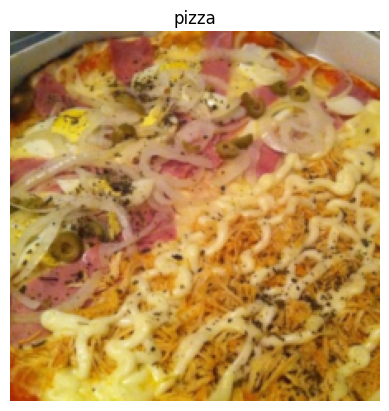

In [11]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [107]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768):
    super().__init__()

    self.patch_size = patch_size

    self.patcher = nn.Conv2d(
        in_channels=in_channels,
        out_channels=embedding_dim,
        kernel_size=patch_size,
        stride=patch_size,
        padding=0
    )

    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # Adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
    return x_flattened.permute(0, 2, 1)


In [82]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

In [83]:
patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(random_image_tensor)
print(f"Input shape: {random_image_tensor.shape}")
print(f"Output shape: {patch_embedding_output.shape} -> (batch_size, num_patches, embedding_dim)")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 196, 768]) -> (batch_size, num_patches, embedding_dim)


In [108]:
class ViT(nn.Module):
  def __init__(
      self,
      img_size:int=224, # Training resolution from Table 3 in ViT paper
      in_channels:int=3, # Number of channels in input image
      patch_size:int=16, # Patch size
      num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
      embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
      mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
      num_heads:int=12, # Heads from Table 1 for ViT-Base
      attn_dropout:float=0, # Dropout for attention projection
      mlp_dropout:float=0.1, # Dropout for dense/MLP layers
      embedding_dropout:float=0.1, # Dropout for patch and position embeddings
      num_classes:int=1000
  ):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

    self.num_patches = (img_size * img_size) // patch_size**2

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True)

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)

    self.transformer_encoder = nn.TransformerEncoder(
        encoder_layer=nn.TransformerEncoderLayer(
            d_model=embedding_dim, # Hidden size D from Table 1 for ViT-Base
            nhead=num_heads, # Heads from Table 1 for ViT-Base
            dim_feedforward=mlp_size, # MLP size from Table 1 for ViT-Base
            dropout=mlp_dropout, # Amount of dropout for dense layers from Table 3 for ViT-Base
            activation="gelu", # GELU non-linear activation
            batch_first=True, # Do our batches come first?
            norm_first=True
        ), # Normalize first or after MSA/MLP layers?,
        num_layers=num_transformer_layers
    )

    self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]

    class_token = self.class_embedding.expand(batch_size, -1, -1)

    x = self.patch_embedding(x)

    x = torch.cat((class_token, x), dim=1)

    x = self.position_embedding + x

    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)

    x = self.classifier(x[:, 0])

    return x


In [109]:
# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.7133, -1.2794, -0.1357]], grad_fn=<AddmmBackward0>)

In [110]:
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                 [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                            [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                           [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                      [32, 197, 768]       [32, 197, 768]       --                   --
├─TransformerEncoder (transformer_encoder)         [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)        

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [113]:
from going_modular.going_modular.vit import ViT as ModularizedViT

In [114]:
modularized_vit = ModularizedViT(num_classes=len(class_names))

summary(model=modularized_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [32, 3, 224, 224]    [32, 3]              7,239,936            True
├─PatchEmbedding (patch_embedding)                 [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                            [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                           [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                      [32, 197, 768]       [32, 197, 768]       --                   --
├─TransformerEncoder (transformer_encoder)         [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)        

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [116]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
train_dir_20_percent = data_20_percent_path / "train"

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [115]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

embedding_dim = 768

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [117]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [118]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.6443 | train_acc: 0.7521 | test_loss: 0.2314 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.2036 | train_acc: 0.9167 | test_loss: 0.2301 | test_acc: 0.9186
Epoch: 3 | train_loss: 0.1399 | train_acc: 0.9583 | test_loss: 0.1990 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.1000 | train_acc: 0.9688 | test_loss: 0.1778 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.0881 | train_acc: 0.9771 | test_loss: 0.1803 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.0924 | train_acc: 0.9521 | test_loss: 0.1705 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.0655 | train_acc: 0.9812 | test_loss: 0.1785 | test_acc: 0.9583
Epoch: 8 | train_loss: 0.0575 | train_acc: 0.9875 | test_loss: 0.2006 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.0657 | train_acc: 0.9938 | test_loss: 0.2046 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0411 | train_acc: 0.9938 | test_loss: 0.1877 | test_acc: 0.9280


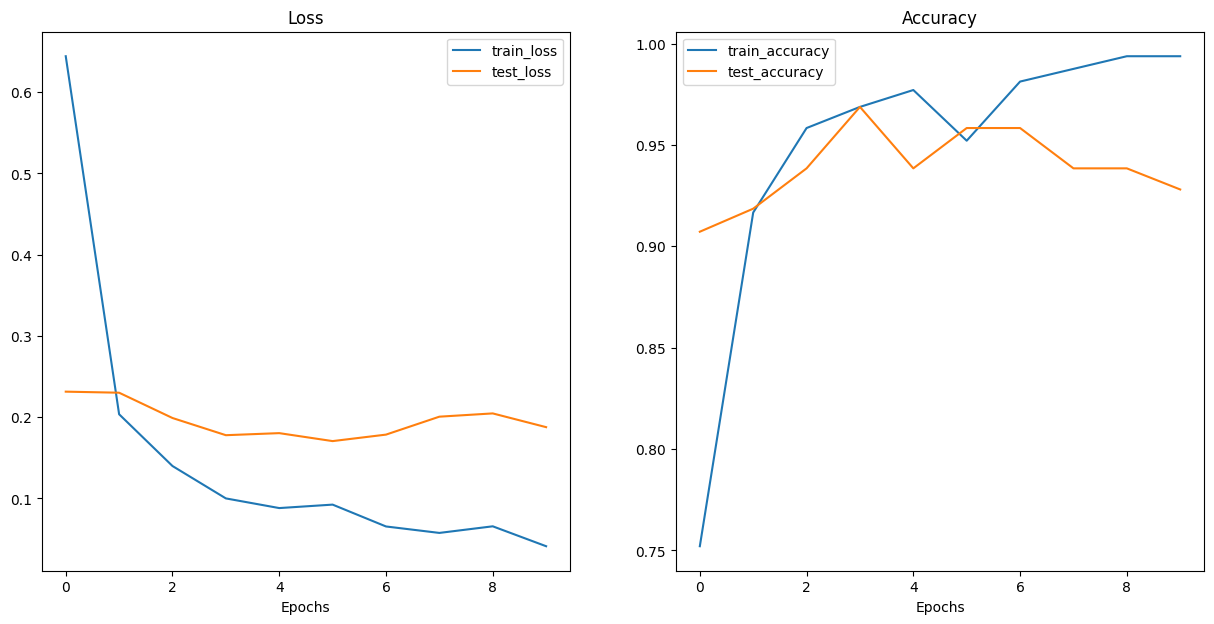

In [119]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [120]:
pretrained_vit_swag_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # requires torchvision >= 0.13, "DEFAULT" means best available

pretrained_vit_swag = torchvision.models.vit_b_16(weights=pretrained_vit_swag_weights).to(device)

embedding_dim = 768

for parameter in pretrained_vit_swag.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

summary(model=pretrained_vit_swag,
        input_size=(1, 3, 384, 384), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [121]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_swag_transforms = pretrained_vit_swag_weights.transforms()

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_swag_transforms,
                                                                                                     batch_size=32)

In [122]:
optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit_swag,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.4661 | train_acc: 0.9000 | test_loss: 0.0779 | test_acc: 0.9792
Epoch: 2 | train_loss: 0.0641 | train_acc: 0.9854 | test_loss: 0.0619 | test_acc: 0.9896
Epoch: 3 | train_loss: 0.0407 | train_acc: 0.9875 | test_loss: 0.0488 | test_acc: 0.9896
Epoch: 4 | train_loss: 0.0300 | train_acc: 0.9938 | test_loss: 0.0427 | test_acc: 0.9896
Epoch: 5 | train_loss: 0.0241 | train_acc: 0.9938 | test_loss: 0.0435 | test_acc: 0.9896
Epoch: 6 | train_loss: 0.0205 | train_acc: 0.9979 | test_loss: 0.0405 | test_acc: 0.9896
Epoch: 7 | train_loss: 0.0168 | train_acc: 0.9979 | test_loss: 0.0387 | test_acc: 0.9896
Epoch: 8 | train_loss: 0.0197 | train_acc: 0.9979 | test_loss: 0.0396 | test_acc: 0.9896
Epoch: 9 | train_loss: 0.0131 | train_acc: 1.0000 | test_loss: 0.0489 | test_acc: 0.9896
Epoch: 10 | train_loss: 0.0123 | train_acc: 0.9979 | test_loss: 0.0403 | test_acc: 0.9896
